In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import Tide_API as tide
import Depth_profile as depth

In [3]:
#importing required packages
import os
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from datetime import datetime

# Depth profile

In [2]:
#converts the hdf5 file to a pandas dataframe 
def get_photons(f):
    l1 = unpack_photons(f['heights'])

    return l1

#extracts the height, lat,lon and confidence of photons
def unpack_photons(f):
    #extracting each column 
    height = f['h_ph'][...]
    print(height)
    lat = f['lat_ph'][...]
    lon = f['lon_ph'][...]
    print(lon)
    conf = f['signal_conf_ph'][...]
    print(conf)
    #creating the dataframe 
    data = [height,lat,lon,conf]
    df = pd.DataFrame(data).T
    #sets the column names 
    df.columns = ['Height', 'Latitude', 'Longitude','Confidence']
    return df

In [3]:
#splits the confidence array into individual columns
def individual_confidence(df):
    df['Conf_land'] = df.apply(lambda x: x.Confidence[0], axis = 1)
    df['Conf_ocean'] = df.apply(lambda x: x.Confidence[1], axis = 1)
#     df['Conf_sea_ice'] = df.apply(lambda x: x.Confidence[2], axis = 1)
#     df['Conf_land_ice'] = df.apply(lambda x: x.Confidence[3], axis = 1)
#     df['Conf_inland_water'] = df.apply(lambda x: x.Confidence[4], axis = 1)
    return df

In [4]:
#method to get only the required parts of the h5 file and outputting it as a csv
def convert_h5_to_csv(fp,laser,coords,out_fp,fn):
    #reads in the hdf5 file
    f_df = h5py.File(fp,'r')
    #unpacks the hdf5 file to a pandas dataframe
    df_laser = get_photons(f_df[laser])
    #gets the coordinates that are within the coordinates passed into the function 
    df = df_laser.loc[(df_laser.Latitude > coords[0]) & (df_laser.Latitude < coords[1]) & (df_laser.Longitude > coords[2]) & (df_laser.Longitude < coords[3])]
    #unpacks the confidence array to individual columns
    df = individual_confidence(df)
    #creates a file with the reef name if it does not exist 
    if not os.path.exists(out_fp):
        os.makedirs(out_fp)
    #writes a dataframe containing just the photon data that is required 
    df.to_csv(out_fp + '/Photon/'+ out_fp.split('/')[-1] + '_photons_' + fn.split('.')[0] + '_' + laser + '.csv')
    return

In [5]:
#method to predict the water level   
def water_level(df):
    #getting just high confidence ocean photons 
    df = df.loc[df.Conf_ocean == 4]
    #getting photons +- 2 of the median height of photons 
    df = df.loc[(df.Height > df.Height.median() - 2) & (df.Height < df.Height.median() + 2)]
    water = []
    lat = []
    
    #creating a df with just the latitude and height 
    sea_level = (pd.DataFrame([df.Height,df.Latitude]).T.dropna())
    sea_level.columns = ['water','latitude']
    
    #getting photons +- 1.25 of the median height of photons 
    sea_level = sea_level.loc[(sea_level.water > sea_level.water.median() -1.25) & (sea_level.water < sea_level.water.median() +1.25)]
    #fitting linear line to remaining points 
    z = np.polyfit(sea_level.latitude, sea_level.water,1)
    f = np.poly1d(z)
    print(f)
    #getting absolute error for each point 
    sea_level['abs_diff'] = np.abs(sea_level.water - f(sea_level.latitude))
    #retaining only points with absolute error less than 2
    sea_level = sea_level.loc[sea_level.abs_diff < 2]
    #fitting a parabolic function to the remaining points
    z2 = np.polyfit(sea_level.latitude, sea_level.water,2)
    f2 = np.poly1d(z2)
    print('func')
    print(f2)
    #return the function 
    return f2

In [6]:
def depth_profile_adaptive(df, out_path,tide_level):
    #generating function to get the water level
    f = water_level(df)
    
    #creating copies of the dataset
    df = df.copy()
    m = df.copy()
    

    #subsetting the dataset by ICESAT confidence scores
    m = m.loc[(m.Conf_ocean == 4) | (m.Conf_land == 4)]
    #readjusting depths to the sea level
    sea = f(m.Latitude)
    mean_sea = np.mean(sea)
    df.Height = df.Height - mean_sea
    m.Height = m.Height - mean_sea
    sea = sea - np.mean(sea)
    
    #threshold below sea level for which we consider reefs 
    thresh = 1
    
    #generating arrays for the height, latitude 
    h = []
    l = []

    #iterating through the latitudes 0.0005˚ at a time 
    start = df.Latitude.min()
    end = df.Latitude.max()
    dx = 0.0005
    
    #getting just high confidence land photons 
    df = df.loc[(df.Conf_land == 4)]
    
    #sorting photons by latitude
    df = df.sort_values('Latitude')
    
    #getting line for longitudes
    lon_samples = df.sample(min(1000, len(df)))
    z1 = np.polyfit(lon_samples.Latitude, lon_samples.Longitude,1)
    lon_func = np.poly1d(z1)
    
    while start <= end:
        #subsetting photons that fall within window of size dx
        temp = df.loc[(df.Latitude >= start) & (df.Latitude <start+dx)]
        t = temp.copy()
        #getting the midpoint latitude of the window
        mean_lat = (temp.Latitude.max() + temp.Latitude.min()) / 2
        #subsetting photons 1m below sea level
        temp = temp.loc[(temp.Height < f(mean_lat) - mean_sea- thresh)]
        
        #getting the IQR of photons
        uq = temp["Height"].quantile(0.75)
        lq = temp["Height"].quantile(0.25)
        temp = temp.loc[(temp.Height >= lq) & (temp.Height < uq) ]        
        
        #if IQR contains more than 3 photons we proceed with the depth analysis
        if temp.shape[0] > 3:
            #getting depths that we will iterate throguh 
            min_depth = math.ceil(temp.Height.min()-1)
            max_depth = min(0,math.ceil(temp.Height.max()))
            median_depth = pd.DataFrame()
    
            #iterating through intervals of 0.5m at a time 
            for x in range(min_depth,max_depth):
                for y in range(2):
                    #subsetting photons within each 0.5m interval
                    depth_intervals = temp.loc[(temp.Height >= x + (y/2)) & (temp.Height < x+ ((y+1)/2))]
                    #if the interval contains one or more photons we will store the photon information for future calculations 
                    if depth_intervals.shape[0] >=1:
                        median_depth = pd.concat([depth_intervals,median_depth])
            
            #if more than 2 photons are saved from the previous step we set the median to be the predicted height
            if median_depth.shape[0] >= 2:
                h.append(median_depth.Height.median())
            else:
                #else nan
                h.append(np.nan)
            
            #append the mid point of the latitude to represent the latitude for the calculated height
            l.append((start + start+dx)/2)
#             print('first',l[-1],h[-1])
            #move to the next window
            start += dx
            
        #if the IQR does not contain more than 3 photons we use an adaptive window 
        else:
            #we have already completed the first iteration by checking if the window has more than 3 photons
            i = 2
            #boolean flag to check if we have met the requirements to make a prediction 
            bool_check = False
            #saving the starting latitude 
            ts = start
            #adaptive window check done at max 4 times 
            while i <= 4:
                #subset data in the window 
                temp = df.loc[(df.Latitude >= start-(i*(dx/2))) & (df.Latitude <start+(i*(dx/2)))]
                #get the midpoint of the latitudes in the window 
                mean_lat = (temp.Latitude.max() + temp.Latitude.min()) / 2
                #get photons more than 1m below sea level
                temp = temp.loc[(temp.Height < f(mean_lat) - mean_sea- thresh)]
                
                #setting counter to move to the next adaptive window
                i+=1
                #check if there are more than 30 photons in the window 
                if temp.shape[0] > 30:
                    
                    #find depths through which we will iterate
                    min_depth = math.ceil(temp.Height.min()-1)
                    max_depth = min(0,math.ceil(temp.Height.max()))
                    median_depth = pd.DataFrame()
                    #iterate through depths of 0.5m at a time 
                    for x in range(min_depth,max_depth):
                        for y in range(2):
                            depth_intervals = temp.loc[(temp.Height >= x + (y/2)) & (temp.Height < x+ ((y+1)/2))]
                            #if any depth interval has 2 or more photons, we will store that information for future use 
                            if depth_intervals.shape[0] >=1:
                                median_depth = pd.concat([depth_intervals,median_depth])
                    
                    #if we had more than photons saved from the previous step, we will preduct the median of those photons as the height
                    if median_depth.shape[0] >= 2:
                        #set the boolean flag to true 
                        bool_check = True
                        h.append(median_depth.Height.median())
                        #latitude for the given depth prediction is represented by the latitude midpoint 
                        l.append((start + start+dx)/2)
#                         print('l',l[-1],h[-1])
                        i = 5

            #if we did not meet any of the criteria we will predict nan for the height and the midpoint of the latitude for lat
            if bool_check == False:
                h.append(np.nan)
                l.append((start + start+dx)/2)
#                 print('e',l[-1],h[-1])
            #move to the next window
            start = ts + dx
        
    #remove noise
    for i,x in enumerate(h):
        if i == 0 or i == len(h) - 1 :
            continue
        else:

            if np.isnan(h[i-1]) and np.isnan(h[i+1]):
                if not np.isnan(x):
                    h[i] = np.nan
                
    #creating dataframe with the depth and latitudes
    depth = pd.DataFrame([h,l]).T
    depth.columns = ['Height','Latitude']
    depth['Longitude'] = (lon_func(depth.Latitude))


    d = depth.copy()
    d['Height'] = d['Height'] - tide_level
	#disregards files with less than 10 depth predictions 
    if depth.dropna().shape[0] >= 15:
        d.to_csv(out_path)
    else:
        return pd.DataFrame()
    return depth

In [7]:
#method to extract the date from the filename 
def get_date(fn):
	#finding string sequence with 14 consecutive integers 
    dt = (re.findall('\d{14}',fn)[0])
    #convert string to datetime object
    dt = datetime.strptime(dt, '%Y%m%d%H%M%S')
    return dt

In [8]:
#wrapper function that takes in the reef and outputs the depth profile of each reef with plots if requested
def get_depths(reef_name,plots = True):
	#gets the files and coordinates of the reef
    files, coords = get_fn_coords(reef_name)
    print(coords, files)
    #creates the output files path
    text_path = os.path.join('data',reef_name, str(reef_name) +'.txt')
    #creates the output file and appends the basic information about the coordinates and h5 files associated with
    f = open(text_path,"w")
    f.write('Coordinates:\n')
    f.write(str(coords) + '\n\n')
    f.write('H5 Files:\n')
    for fn in files:
        f.write(fn)
        f.write('\n')

    f.write('\n')
    f.write('Output Files:\n')
    
    out = os.path.join('data', reef_name)
    if not os.path.exists(os.path.join(out,'Depth')):
    	os.makedirs(os.path.join(out,'Depth'))
    	
    if not os.path.exists(os.path.join(out,'Photon')):
    	os.makedirs(os.path.join(out,'Photon'))
    
    
	#looping through each h5 file 
    for fn in files:
        date = get_date(fn)
        #collects the strong lasers for which we will get the depth profile 
        fp = os.path.join('data',reef_name, 'H5' ,fn)
        f_df = h5py.File(fp,'r')
        sc_orient = f_df['orbit_info']['sc_orient'][...][0]
        print(date,'  :  ',sc_orient)
        if sc_orient == 1:
            lasers = ['gt1r', 'gt2r', 'gt3r']
        else:
            lasers = ['gt1l', 'gt2l', 'gt3l']
        #looping through each strong laser 
        for laser in lasers:
        	#creating all the required file paths 
            
            
            depths_fn = reef_name + '_' + fn.split('.')[0] + '_' + laser + '.csv'
            out_depths = os.path.join('data', reef_name, 'Depth',depths_fn)
            existing_file = os.path.join(out,'Photon', str(reef_name) +'_photons_' + fn.split('.')[0] +'_' +laser + '.csv')
            #creates output directory if it does not already exist 
            if not os.path.exists(existing_file):
            	try:
            		convert_h5_to_csv(fp,laser,coords,out,fn)
            	except:
            		continue
			#reads in csv with clipped h5 information 
            reef = pd.read_csv(existing_file)
            #gets the tide on the given day
            tide_level = tide.get_tide((coords[0]+coords[1])/2, (coords[2]+coords[3])/2,date)
            #calculates the depth profile 
            try:
            	depth = depth_profile_adaptive(reef,out_depths,tide_level)
            except:
            	continue
            	
            #if the depth profile is returned we output the out file name to our output text File
            if not depth.empty:
                f.write(out_depths)
                f.write('\n')
                if plots:
                    print(fn,laser)
                    ax = plot(reef, depth,laser)
                
    f.close()
    return 

In [9]:
#method to get the files associated with the reef and its coordinates
def get_fn_coords(reef_name):
    #getting the filepath and opening the respective file 
    path = os.path.join('data',reef_name, str(reef_name) +'.txt')
    f = open(path,"r")
    #variables to store the output values 
    files = []
    coords = []
    next_line = -1
    #looping through the file 
    for i,l in enumerate(f):
        #if the current line is coordinates we want the following line 
        if l == 'Coordinates:\n':
            #extract the coordinates and store it as a list of floats
            coords = (f.readline().strip())
            coords = coords[1:-1].split(',')
            coords = [float(c) for c in coords]
        #if the current line is H5 files
        if l == 'H5 Files:\n':
            # we loop through adding all the h5 files to the list 
            while 1 :
                line = f.readline()
                if not line or line == 'Output Files:\n' or line == '\n': 
                    break 
                files.append(line.strip())
    #close the file 
    f.close()
    #return the files and coordinates 
    return files,coords

In [18]:
#method to plot predicted depths with photon data
def plot(df,depth,laser):
    #getting a function that is fit to the water level
    f = water_level(df)
    #extracting just high confidence ocean and land photons 
    m = df.loc[(df.Conf_ocean == 4) | (df.Conf_land == 4)]
    m = m.loc[(m.Latitude > 3.98) & (m.Latitude < 4.11)]
    m = m.loc[m.Height > -96.46547273238758 - 25]
    #readjusting photon depths to the sea level
    sea = f(m.Latitude)
    mean_sea = np.mean(sea)
    df.Height = df.Height - mean_sea
    m.Height = m.Height - mean_sea
    sea = sea - np.mean(sea)
    print(mean_sea)
#     m = m.loc[m.Height > -30]
    #thresholds to classify photon as land or reef or water 
    threshold = -0.3
    threshold_land = 2
    #plotting the sea, land and reef in different colours based on the thresholds
    sea_level = m.loc[(m.Height > threshold) & (m.Height < threshold_land) ]
    reef = m.loc[m.Height <= threshold]
    land = m.loc[m.Height > threshold_land]
    fig,ax = plt.subplots(figsize=(50,20))
    plt.scatter(sea_level.Latitude, sea_level.Height, s = 0.1)
    plt.scatter(reef.Latitude, reef.Height, s= 1, color = 'green')
    plt.scatter(land.Latitude, land.Height, s =1, color = 'brown')
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    plt.xlabel('Latitude', fontsize = 24)
    plt.ylabel('Height (m)', fontsize = 24)
#     plt.savefig('photon' + laser + '.png')
    #plotting depth predictions on top of the photon data 
    plt.plot(m.Latitude, sea, linestyle='-', marker='o',color='blue', linewidth=2, markersize=2,alpha = 0.4)
    depth_prof = plt.plot(depth.Latitude, depth.Height, linestyle='-', marker='o',color='red', linewidth=7, markersize=4,alpha = 0.4)
    plt.savefig('photon_preds' + laser + '.png')
    return ax



## DHIFFUSHI (MALDIVES)

[3.803554, 4.135101, 73.340536, 73.548742] ['ATL03_20181031214459_05080107_001_01.h5', 'ATL03_20190130172455_05080207_001_01.h5']
2018-10-31 21:44:59   :   1
gt1r
ATL03_20181031214459_05080107_001_01.h5 gt1r


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


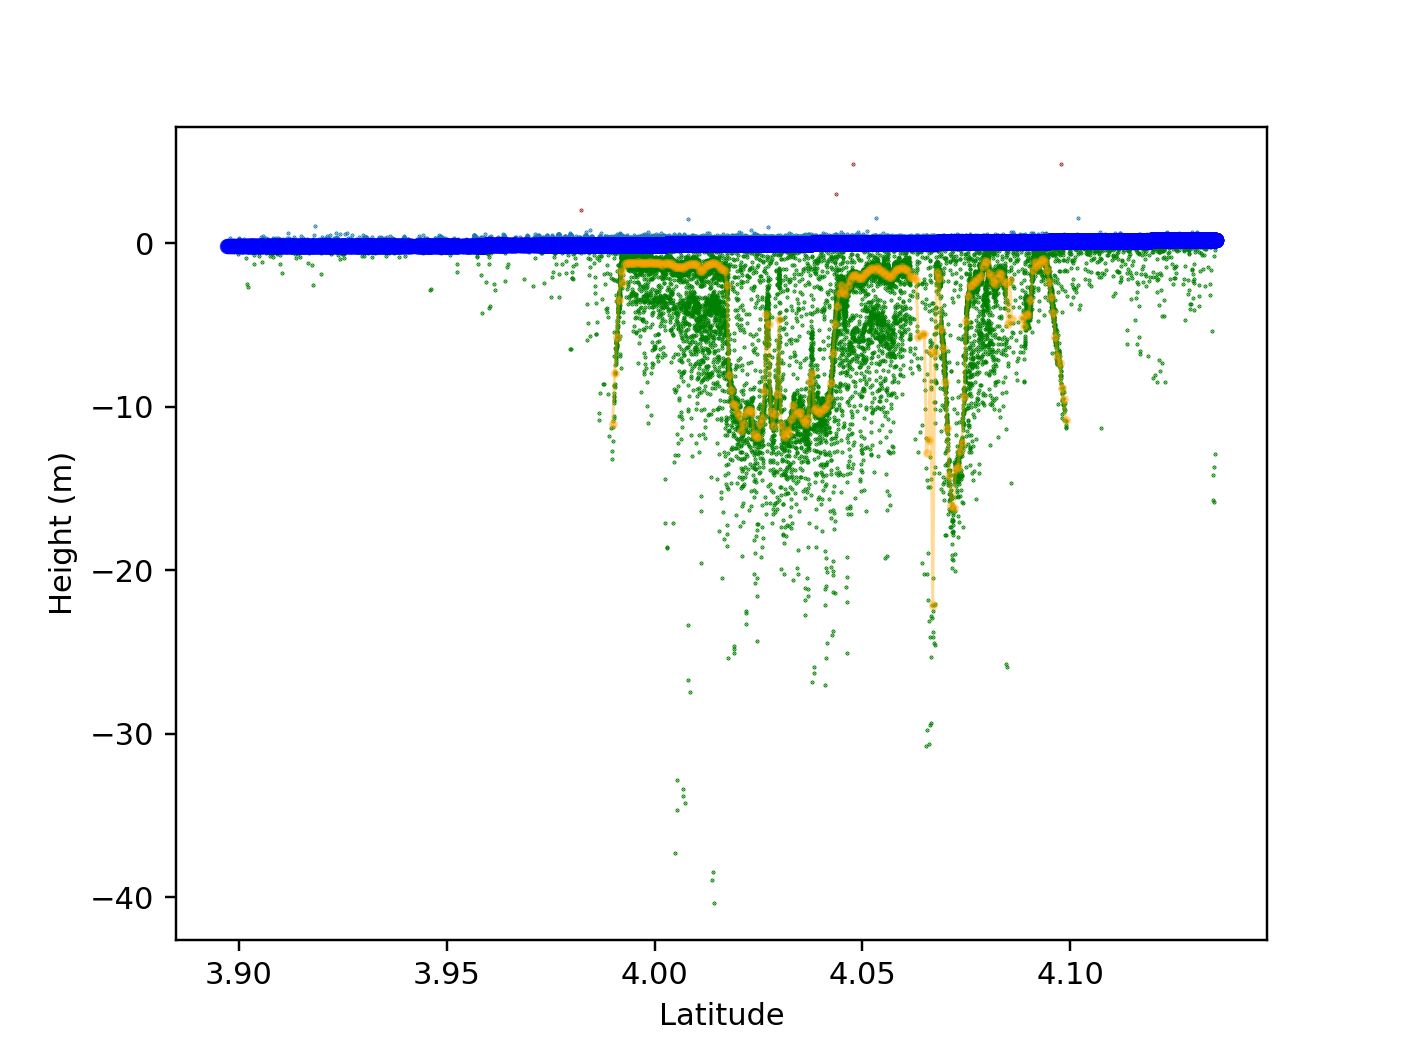

gt2r
ATL03_20181031214459_05080107_001_01.h5 gt2r


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


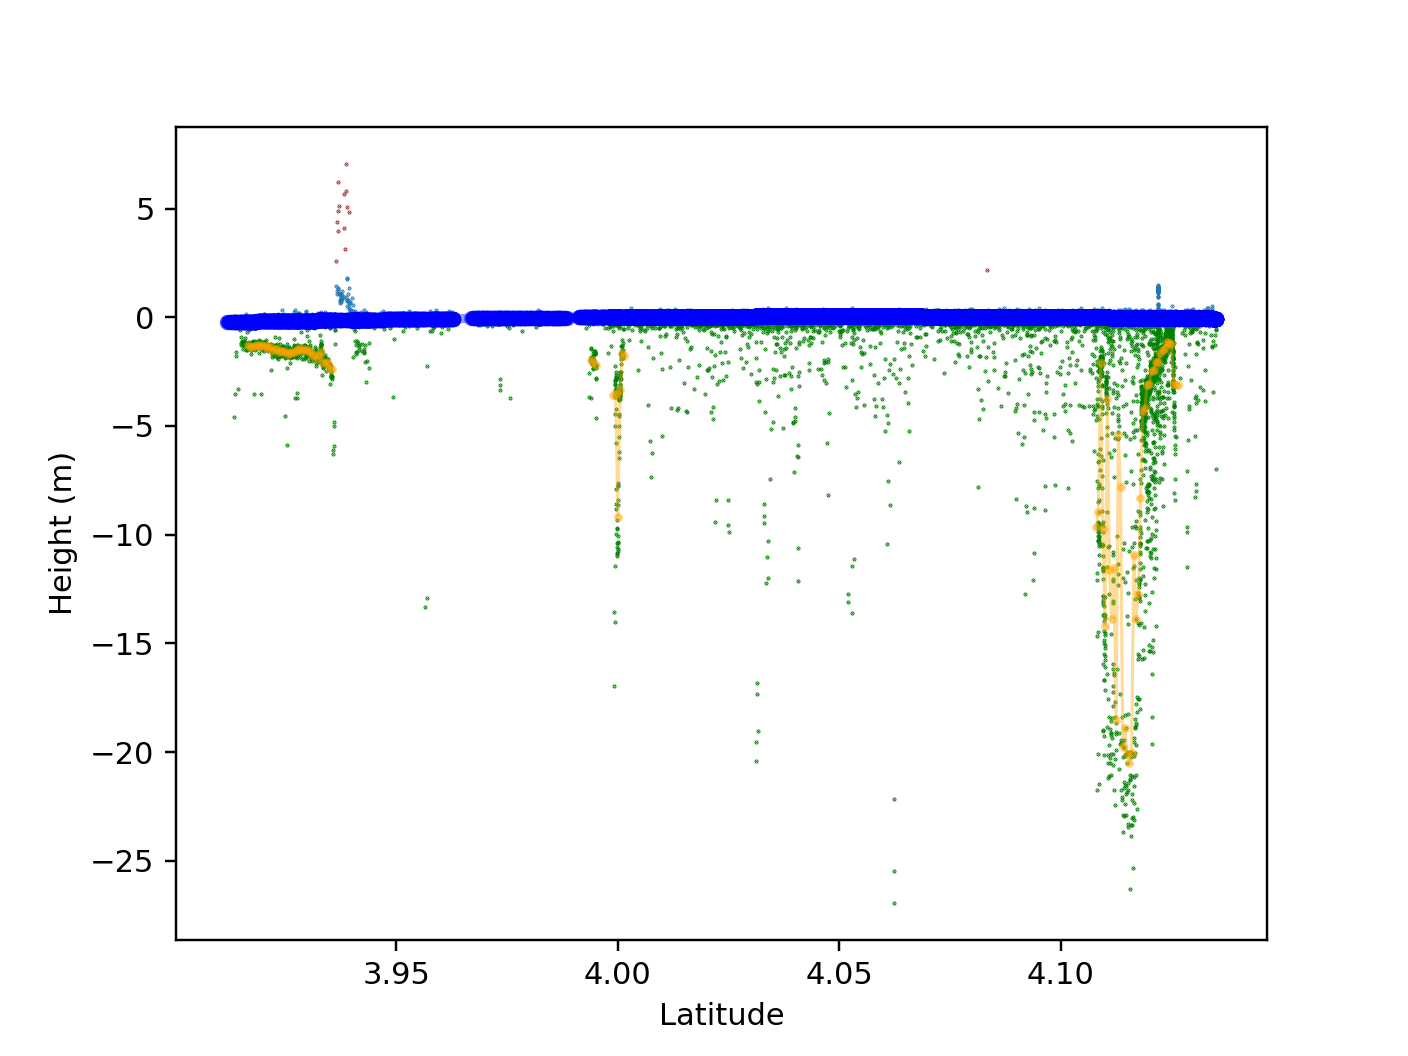

gt3r
ATL03_20181031214459_05080107_001_01.h5 gt3r


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


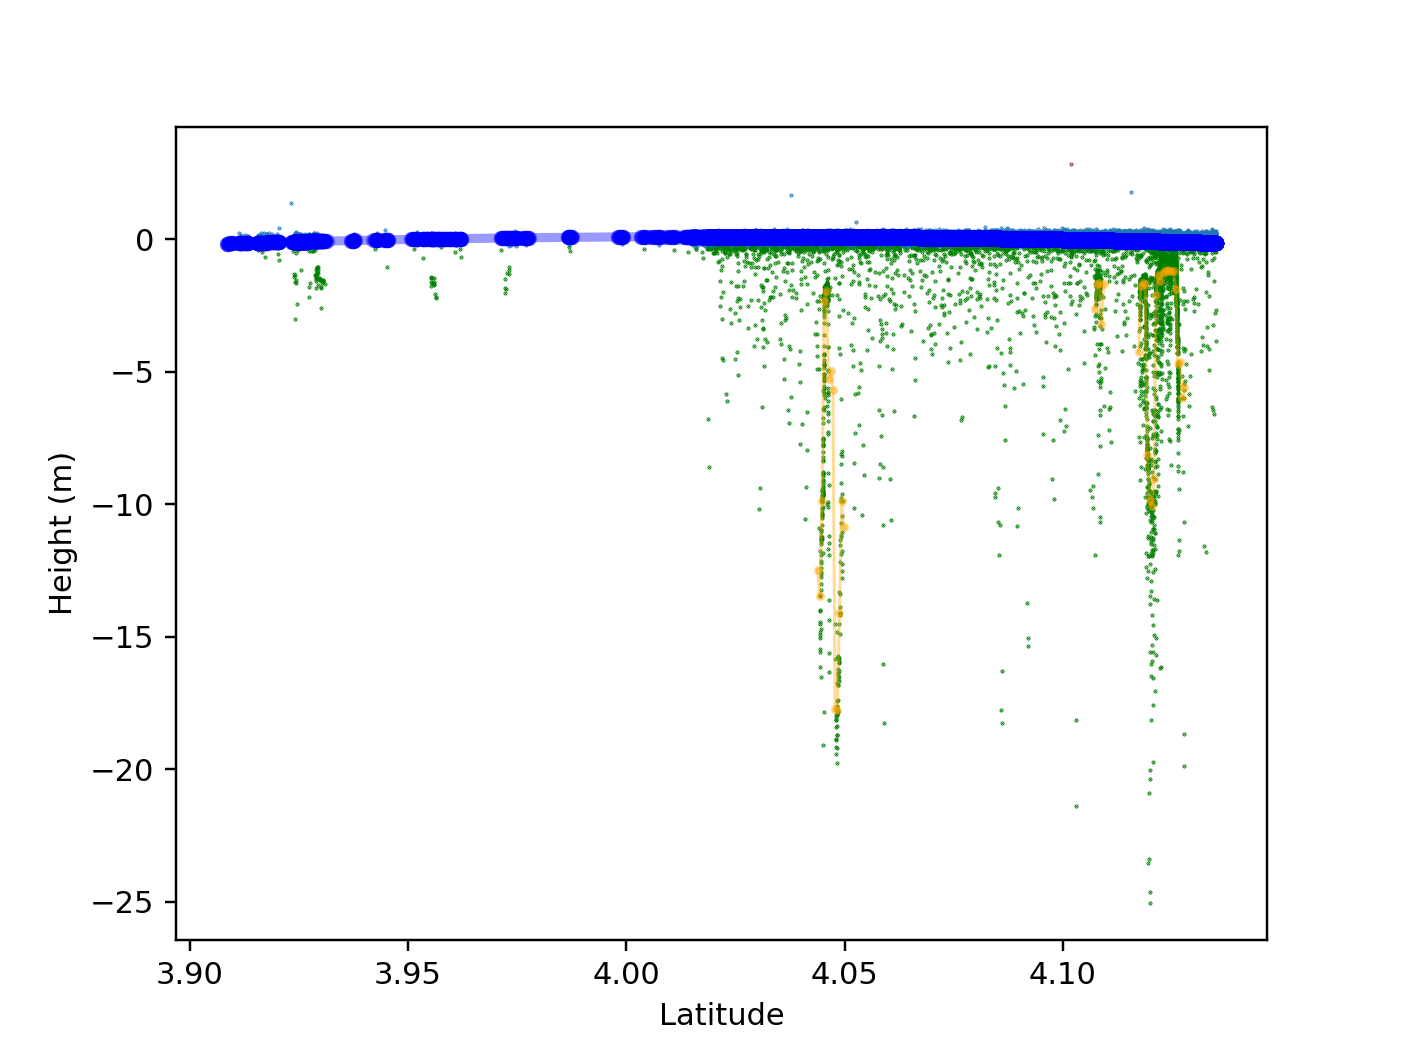

2019-01-30 17:24:55   :   0
gt1l
gt2l
ATL03_20190130172455_05080207_001_01.h5 gt2l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


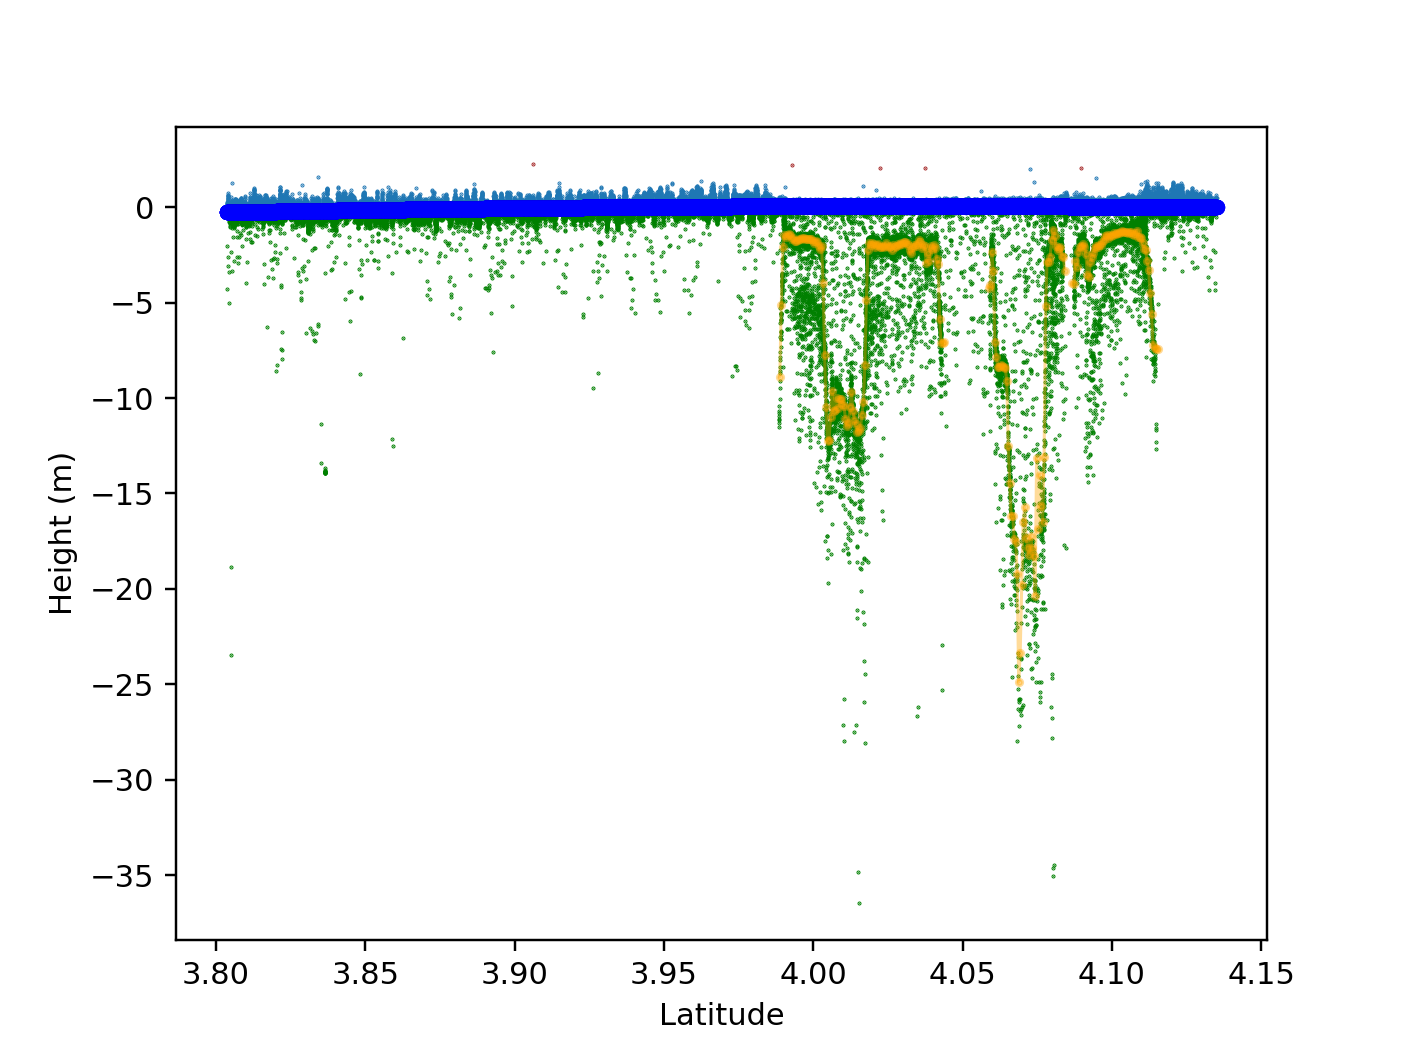

gt3l
ATL03_20190130172455_05080207_001_01.h5 gt3l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


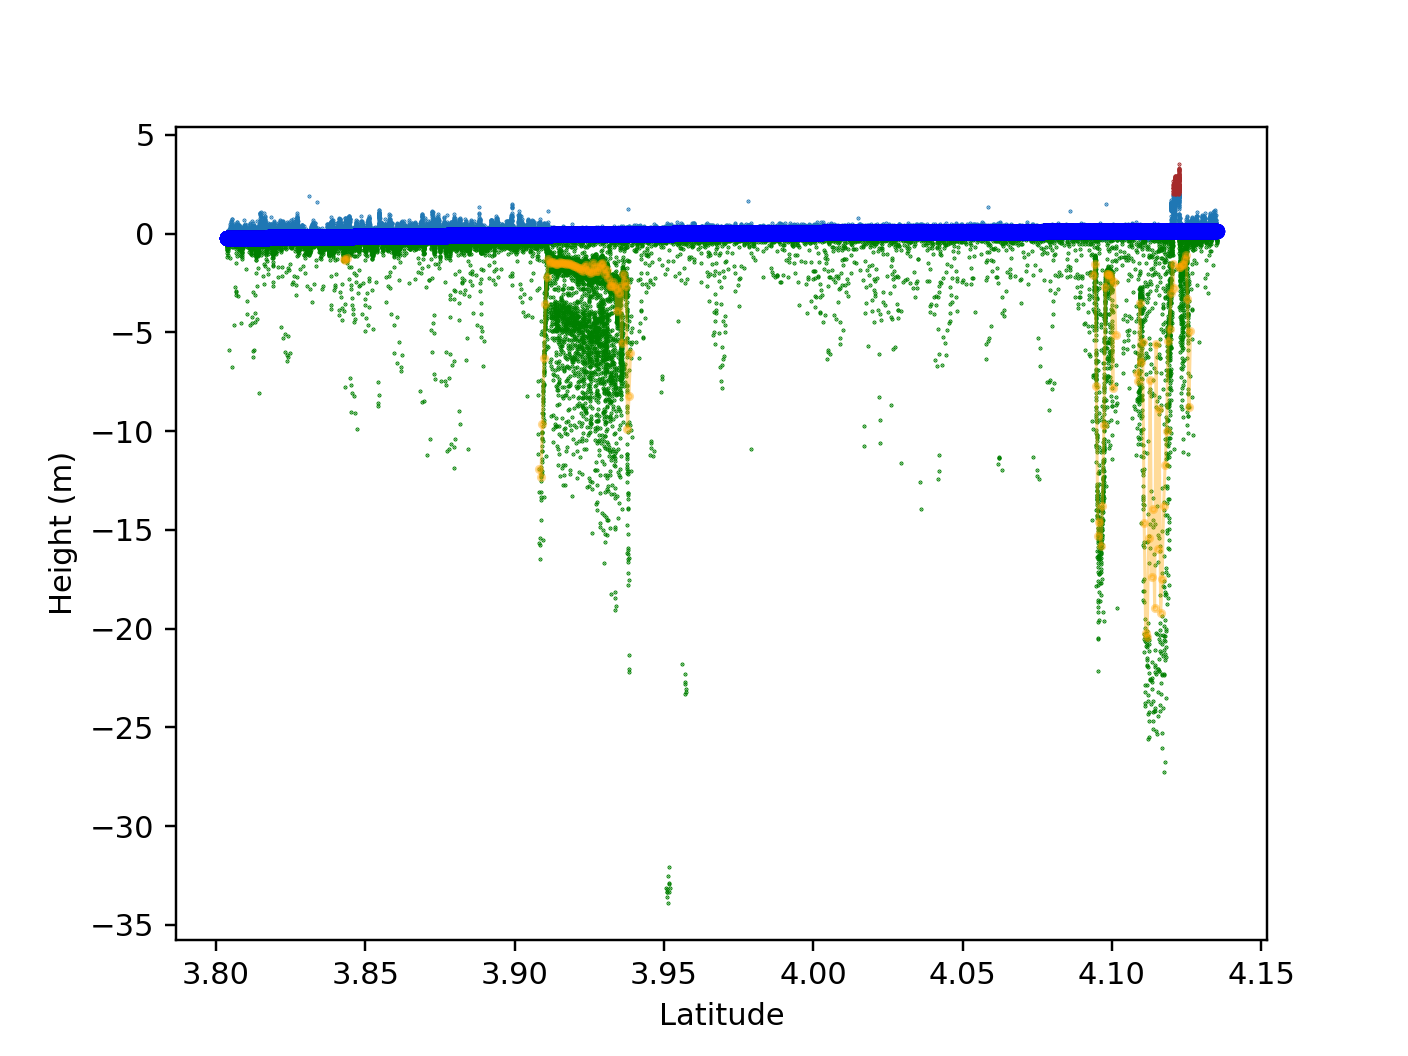

In [8]:
depth.get_depths('Dhiffushi')

## Nasau (Fiji)

In [ ]:
depth.get_depths('Nasau')

[-18.761178, -18.615609, -178.550521, -178.403579] ['ATL03_20190610035647_11130308_002_01.h5', 'ATL03_20190311081711_11130208_001_02.h5', 'ATL03_20181210123712_11130108_001_01.h5']
2019-06-10 03:56:47   :   0
gt1l
ATL03_20190610035647_11130308_002_01.h5 gt1l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>

gt2l
ATL03_20190610035647_11130308_002_01.h5 gt2l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>

gt3l
ATL03_20190610035647_11130308_002_01.h5 gt3l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>

2019-03-11 08:17:11   :   0
gt1l
gt2l
ATL03_20190311081711_11130208_001_02.h5 gt2l


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>

gt3l


## Ono-i-Lau

In [ ]:
depth.get_depths('One-i-Lau')